# Clothing Classification Training with ResNet50

## Imports and Configurations

### Imports

In [13]:
import time
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from tqdm import tqdm
from pathlib import Path
import kagglehub
import shutil
import numpy as np
from sklearn.metrics import precision_score, recall_score, confusion_matrix
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from collections import defaultdict

### Check CUDA Availability

In [14]:
if cuda_available:= torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

device = 'cuda' if cuda_available else 'cpu'
print(f"CUDA Available: {cuda_available}")

GPU: NVIDIA GeForce RTX 3060 Laptop GPU
CUDA Available: True


### Global Variables

In [15]:
THERMAL_MAPPING = {
    'light': [
        'Kaos',  # T-shirt
        'Polo',
        'Celana_Pendek',  # Shorts
        'Gaun',  # Dresses (typically lighter)
        'Rok',  # Skirt
    ],
    'medium': [
        'Celana_Panjang',  # Long Pants
        'Jeans',
        'Blazer',
        'Jaket_Denim',  # Denim Jacket
        'Kemeja' # Shirt
    ],
    'heavy': [
        'Jaket',  # Jacket
        'Jaket_Olahraga',  # Sports Jacket
        'Mantel',  # Coat
        'Sweter',  # Sweater
        'Hoodie',
    ]
}

CLASSES = [key for key in THERMAL_MAPPING.keys()]
NUM_CLASSES = len(CLASSES)
IMG_SIZE = 256
BATCH_SIZE = 32
WEIGHTS_DIR = Path("../../runs/clothing_classification")
WEIGHTS_DIR.mkdir(parents=True, exist_ok=True)
RESULTS_DIR = WEIGHTS_DIR / "results"
DATASET_DIR = Path("../../datasets/clothing_classification")

## Data Preperation

### Download Dataset

In [16]:
path = kagglehub.dataset_download("ryanbadai/clothes-dataset") 
DATASET_DIR.mkdir(parents=True, exist_ok=True) 
src_dir = Path(path) / "Clothes_Dataset" 

for item in src_dir.iterdir(): 
    dest = DATASET_DIR / item.name 
    shutil.move(str(item), str(dest))

100%|██████████| 1.37G/1.37G [00:58<00:00, 25.0MB/s]

Extracting files...


### Organize and Balance Dataset

In [17]:
def reorganize_dataset(source_dir, target_dir, balance=True, seed=42):
    random.seed(seed)

    source_dir = Path(source_dir)
    target_dir = Path(target_dir)

    thermal_images = defaultdict(list)

    for thermal_class, clothing_types in THERMAL_MAPPING.items():
        thermal_path = target_dir / thermal_class
        thermal_path.mkdir(parents=True, exist_ok=True)

        for clothing_type in clothing_types:
            source_path = source_dir / clothing_type
            if not source_path.exists():
                continue

            print(f"Processing {clothing_type} -> {thermal_class}")

            moved_all = True

            for img_file in source_path.iterdir():
                if img_file.suffix.lower() in [".jpg", ".jpeg", ".png"]:
                    target_file = (
                        thermal_path
                        / f"{clothing_type}_{img_file.stem}_{img_file.stat().st_ino}{img_file.suffix}"
                    )
                    try:
                        shutil.move(str(img_file), str(target_file))
                        thermal_images[thermal_class].append(target_file)
                    except Exception as e:
                        print(f"Failed to move {img_file}: {e}")
                        moved_all = False

            if moved_all:
                shutil.rmtree(source_path)
            else:
                print(f"Skipped deleting {source_path} due to errors")

    if balance and thermal_images:
        class_sizes = {k: len(v) for k, v in thermal_images.items()}
        min_size = min(class_sizes.values())

        print("\nClass counts before balancing:")
        for k, v in class_sizes.items():
            print(f"{k}: {v}")

        print(f"\nBalancing to {min_size} images per class\n")

        for thermal_class, images in thermal_images.items():
            if len(images) > min_size:
                images_to_remove = random.sample(images, len(images) - min_size)
                for img_path in images_to_remove:
                    img_path.unlink()

        print("Class counts after balancing:")
        for thermal_class in thermal_images:
            final_count = len(list((target_dir / thermal_class).glob("*")))
            print(f"{thermal_class}: {final_count}")
            
reorganize_dataset(DATASET_DIR, DATASET_DIR)

Processing Kaos -> light
Processing Polo -> light
Processing Celana_Pendek -> light
Processing Gaun -> light
Processing Rok -> light
Processing Celana_Panjang -> medium
Processing Jeans -> medium
Processing Blazer -> medium
Processing Jaket_Denim -> medium
Processing Kemeja -> medium
Processing Jaket -> heavy
Processing Jaket_Olahraga -> heavy
Processing Mantel -> heavy
Processing Sweter -> heavy
Processing Hoodie -> heavy

Class counts before balancing:
light: 2500
medium: 2500
heavy: 2500

Balancing to 2500 images per class

Class counts after balancing:
light: 2500
medium: 2500
heavy: 2500


### Data Transformers

In [18]:
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(
        IMG_SIZE,
        scale=(0.8, 1.0),  
        ratio=(0.85, 1.15)
    ),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(
        brightness=0.3,
        contrast=0.3,
        saturation=0.2, 
        hue=0.1 
    ),
    transforms.RandomAffine(
        degrees=0,
        translate=(0.1, 0.1),
        scale=(0.9, 1.1),
        shear=5 
    ),
    transforms.RandomApply([
        transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))
    ], p=0.1),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.3),
    transforms.RandomErasing(p=0.1, scale=(0.02, 0.15), ratio=(0.3, 3.3)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

### Dataset Split and Loaders

In [19]:
full_dataset = datasets.ImageFolder(
    root = DATASET_DIR,
    transform=train_transforms
)

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
val_dataset.dataset.transform = val_transforms

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("Train samples:", len(train_dataset))
print("Val samples:", len(val_dataset))

Train samples: 6000
Val samples: 1500


## Training

### Load ResNet-50 Base Model

In [20]:
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
DEVICE = torch.device(device)


# Replace classifier head
model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)

model = model.to(DEVICE)

### Helper Functions

In [21]:
history = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "accuracy": [],
    "precision": [],
    "recall": [],
    "confusion_matrices": [],
}

def plot_classification_training_results( history: dict, class_names=("sitting", "standing"), 
                                         save_path="results/posture_training_results.png" ):
    epochs = range(1, len(history["val_loss"]) + 1)
    fig, axes = plt.subplots(2, 3, figsize=(18, 8))

    # ---- Loss ----
    axes[0, 0].plot(epochs, history["train_loss"], label="train")
    axes[0, 0].plot(epochs, history["val_loss"], label="val")
    axes[0, 0].set_title("Loss")
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    # ---- Accuracy ----
    axes[0, 1].plot(epochs, history["accuracy"])
    axes[0, 1].set_title("Accuracy")
    axes[0, 1].grid(True)

    # ---- Precision ----
    axes[0, 2].plot(epochs, history["precision"])
    axes[0, 2].set_title("Precision")
    axes[0, 2].grid(True)

    # ---- Recall ----
    axes[1, 0].plot(epochs, history["recall"])
    axes[1, 0].set_title("Recall")
    axes[1, 0].grid(True)

    # ---- Confusion Matrix (last epoch) ----
    cm = history["confusion_matrices"][-1]
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names,
        ax=axes[1, 1],
    )
    axes[1, 1].set_title("Confusion Matrix (Final Epoch)")
    axes[1, 1].set_xlabel("Predicted")
    axes[1, 1].set_ylabel("True")

    # Empty last subplot
    axes[1, 2].axis("off")

    plt.tight_layout()
    save_path = Path(save_path)
    save_path.parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(save_path, dpi=200)
    plt.close()

    print(f"Training results saved to {save_path}")
    return Image.open(save_path)
    

def validate(model, loader, criterion, device):
    model.eval()

    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            labels = labels.to(device)

            outputs = model(imgs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * imgs.size(0)

            preds = torch.argmax(outputs, dim=1)

            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    accuracy = (all_preds == all_labels).mean()

    precision = precision_score(
        all_labels, all_preds, average="macro", zero_division=0
    )
    recall = recall_score(
        all_labels, all_preds, average="macro", zero_division=0
    )

    cm = confusion_matrix(all_labels, all_preds)

    return {
        "loss": running_loss / len(loader.dataset),
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "confusion_matrix": cm
    }

### Initial Training

In [22]:
# Training params
EPOCHS = 25
LR = 3e-2  # Appropriate for SGD
BEST_MODEL_NAME = "resnet50_clothing_classification_best.pth"
FINAL_MODEL_NAME = "resnet50_clothing_classification_initial.pth"

# Freeze pretrained layers initially
for param in model.parameters():
    param.requires_grad = False

for param in model.fc.parameters():
    param.requires_grad = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3)

best_val_acc = 0.0
for epoch in range(EPOCHS):
    model.train()
    start = time.time()

    running_loss = 0.0
    correct = 0
    total = 0

    print(f"\nEpoch {epoch+1}/{EPOCHS} | Image Size {IMG_SIZE}")
    pbar = tqdm(train_loader, leave=False)
    for imgs, labels in pbar:
        imgs = imgs.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        
        # Gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total

    # Validation
    metrics = validate(model, val_loader, criterion, DEVICE)
    val_acc = metrics["accuracy"]
    
    # Step scheduler based on validation accuracy
    scheduler.step(val_acc)

    elapsed = time.time() - start

    # Save metrics
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(metrics["loss"])
    history["accuracy"].append(metrics["accuracy"])
    history["precision"].append(metrics["precision"])
    history["recall"].append(metrics["recall"])
    history["confusion_matrices"].append(metrics["confusion_matrix"])

    print(f"Train Loss: {train_loss:.3f} | Train Acc: {train_acc:.3f}")
    print(f"Val Loss:   {metrics['loss']:.3f} | Val Acc:    {val_acc:.3f}")
    print(f"Val Prec:   {metrics['precision']:.3f} | Val Rec:    {metrics['recall']:.3f}")

    print("\nConfusion Matrix:")
    print(f"{'':12}{CLASSES[0]:>12}{CLASSES[1]:>12}{CLASSES[2]:>12}")
    for i, row in enumerate(metrics['confusion_matrix']):
        print(f"{CLASSES[i]:12}{row[0]:12}{row[1]:12}{row[2]:12}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), WEIGHTS_DIR / BEST_MODEL_NAME)
        print(f"New best model saved (val_acc={best_val_acc:.4f})")
   
    print(f"Epoch time: {elapsed:.1f}s")

# Save final model
torch.save(model.state_dict(), WEIGHTS_DIR / FINAL_MODEL_NAME)
print(f"\nFinal model saved to {WEIGHTS_DIR / FINAL_MODEL_NAME}")
print(f"Best validation accuracy: {best_val_acc:.4f}")


Epoch 1/25 | Image Size 256


Train Loss: 0.649 | Train Acc: 0.724
Val Loss:   0.564 | Val Acc:    0.771
Val Prec:   0.780 | Val Rec:    0.768

Confusion Matrix:
                   light      medium       heavy
light                399          76          32
medium                44         445          26
heavy                 74          92         312
New best model saved (val_acc=0.7707)
Epoch time: 123.0s

Epoch 2/25 | Image Size 256


Train Loss: 0.509 | Train Acc: 0.794
Val Loss:   0.528 | Val Acc:    0.801
Val Prec:   0.802 | Val Rec:    0.800

Confusion Matrix:
                   light      medium       heavy
light                423          39          45
medium                53         418          44
heavy                 67          50         361
New best model saved (val_acc=0.8013)
Epoch time: 144.7s

Epoch 3/25 | Image Size 256


Train Loss: 0.451 | Train Acc: 0.827
Val Loss:   0.558 | Val Acc:    0.788
Val Prec:   0.790 | Val Rec:    0.788

Confusion Matrix:
                   light      medium       heavy
light                422          25          60
medium                62         385          68
heavy                 58          45         375
Epoch time: 145.1s

Epoch 4/25 | Image Size 256


Train Loss: 0.429 | Train Acc: 0.829
Val Loss:   0.538 | Val Acc:    0.793
Val Prec:   0.798 | Val Rec:    0.791

Confusion Matrix:
                   light      medium       heavy
light                444          35          28
medium                67         410          38
heavy                 85          58         335
Epoch time: 139.5s

Epoch 5/25 | Image Size 256


Train Loss: 0.416 | Train Acc: 0.835
Val Loss:   0.520 | Val Acc:    0.792
Val Prec:   0.794 | Val Rec:    0.790

Confusion Matrix:
                   light      medium       heavy
light                414          53          40
medium                45         433          37
heavy                 72          65         341
Epoch time: 136.5s

Epoch 6/25 | Image Size 256


Train Loss: 0.387 | Train Acc: 0.847
Val Loss:   0.503 | Val Acc:    0.802
Val Prec:   0.802 | Val Rec:    0.801

Confusion Matrix:
                   light      medium       heavy
light                423          34          50
medium                56         417          42
heavy                 59          56         363
New best model saved (val_acc=0.8020)
Epoch time: 135.7s

Epoch 7/25 | Image Size 256


Train Loss: 0.373 | Train Acc: 0.852
Val Loss:   0.538 | Val Acc:    0.785
Val Prec:   0.785 | Val Rec:    0.785

Confusion Matrix:
                   light      medium       heavy
light                399          36          72
medium                54         403          58
heavy                 53          50         375
Epoch time: 137.0s

Epoch 8/25 | Image Size 256


Train Loss: 0.368 | Train Acc: 0.854
Val Loss:   0.584 | Val Acc:    0.777
Val Prec:   0.788 | Val Rec:    0.779

Confusion Matrix:
                   light      medium       heavy
light                384          26          97
medium                50         370          95
heavy                 33          34         411
Epoch time: 135.7s

Epoch 9/25 | Image Size 256


Train Loss: 0.359 | Train Acc: 0.860
Val Loss:   0.574 | Val Acc:    0.785
Val Prec:   0.790 | Val Rec:    0.786

Confusion Matrix:
                   light      medium       heavy
light                384          39          84
medium                40         397          78
heavy                 43          38         397
Epoch time: 136.3s

Epoch 10/25 | Image Size 256


Train Loss: 0.347 | Train Acc: 0.868
Val Loss:   0.552 | Val Acc:    0.785
Val Prec:   0.789 | Val Rec:    0.786

Confusion Matrix:
                   light      medium       heavy
light                414          26          67
medium                64         377          74
heavy                 51          40         387
Epoch time: 136.6s

Epoch 11/25 | Image Size 256


Train Loss: 0.307 | Train Acc: 0.886
Val Loss:   0.532 | Val Acc:    0.797
Val Prec:   0.797 | Val Rec:    0.796

Confusion Matrix:
                   light      medium       heavy
light                422          38          47
medium                53         414          48
heavy                 64          55         359
Epoch time: 137.7s

Epoch 12/25 | Image Size 256


Train Loss: 0.311 | Train Acc: 0.883
Val Loss:   0.534 | Val Acc:    0.801
Val Prec:   0.801 | Val Rec:    0.801

Confusion Matrix:
                   light      medium       heavy
light                401          50          56
medium                37         428          50
heavy                 48          57         373
Epoch time: 135.8s

Epoch 13/25 | Image Size 256


Train Loss: 0.302 | Train Acc: 0.887
Val Loss:   0.532 | Val Acc:    0.800
Val Prec:   0.800 | Val Rec:    0.800

Confusion Matrix:
                   light      medium       heavy
light                408          41          58
medium                51         408          56
heavy                 48          46         384
Epoch time: 134.7s

Epoch 14/25 | Image Size 256


Train Loss: 0.305 | Train Acc: 0.888
Val Loss:   0.517 | Val Acc:    0.799
Val Prec:   0.799 | Val Rec:    0.799

Confusion Matrix:
                   light      medium       heavy
light                408          45          54
medium                44         420          51
heavy                 52          55         371
Epoch time: 135.0s

Epoch 15/25 | Image Size 256


Train Loss: 0.289 | Train Acc: 0.895
Val Loss:   0.522 | Val Acc:    0.796
Val Prec:   0.796 | Val Rec:    0.796

Confusion Matrix:
                   light      medium       heavy
light                403          45          59
medium                42         420          53
heavy                 53          54         371
Epoch time: 133.6s

Epoch 16/25 | Image Size 256


Train Loss: 0.298 | Train Acc: 0.887
Val Loss:   0.521 | Val Acc:    0.803
Val Prec:   0.803 | Val Rec:    0.803

Confusion Matrix:
                   light      medium       heavy
light                420          33          54
medium                54         406          55
heavy                 50          49         379
New best model saved (val_acc=0.8033)
Epoch time: 134.8s

Epoch 17/25 | Image Size 256


Train Loss: 0.296 | Train Acc: 0.893
Val Loss:   0.528 | Val Acc:    0.797
Val Prec:   0.796 | Val Rec:    0.796

Confusion Matrix:
                   light      medium       heavy
light                414          38          55
medium                49         413          53
heavy                 57          53         368
Epoch time: 137.7s

Epoch 18/25 | Image Size 256


Train Loss: 0.295 | Train Acc: 0.895
Val Loss:   0.514 | Val Acc:    0.801
Val Prec:   0.800 | Val Rec:    0.800

Confusion Matrix:
                   light      medium       heavy
light                411          43          53
medium                41         424          50
heavy                 53          59         366
Epoch time: 136.6s

Epoch 19/25 | Image Size 256


Train Loss: 0.297 | Train Acc: 0.893
Val Loss:   0.528 | Val Acc:    0.804
Val Prec:   0.804 | Val Rec:    0.804

Confusion Matrix:
                   light      medium       heavy
light                414          36          57
medium                48         415          52
heavy                 50          51         377
New best model saved (val_acc=0.8040)
Epoch time: 135.7s

Epoch 20/25 | Image Size 256


Train Loss: 0.297 | Train Acc: 0.891
Val Loss:   0.534 | Val Acc:    0.804
Val Prec:   0.803 | Val Rec:    0.803

Confusion Matrix:
                   light      medium       heavy
light                416          40          51
medium                44         418          53
heavy                 52          54         372
Epoch time: 135.7s

Epoch 21/25 | Image Size 256


Train Loss: 0.294 | Train Acc: 0.890
Val Loss:   0.530 | Val Acc:    0.795
Val Prec:   0.795 | Val Rec:    0.795

Confusion Matrix:
                   light      medium       heavy
light                403          43          61
medium                43         410          62
heavy                 48          50         380
Epoch time: 135.7s

Epoch 22/25 | Image Size 256


Train Loss: 0.297 | Train Acc: 0.893
Val Loss:   0.524 | Val Acc:    0.807
Val Prec:   0.807 | Val Rec:    0.807

Confusion Matrix:
                   light      medium       heavy
light                414          39          54
medium                45         423          47
heavy                 50          54         374
New best model saved (val_acc=0.8073)
Epoch time: 134.3s

Epoch 23/25 | Image Size 256


Train Loss: 0.292 | Train Acc: 0.893
Val Loss:   0.521 | Val Acc:    0.801
Val Prec:   0.801 | Val Rec:    0.801

Confusion Matrix:
                   light      medium       heavy
light                405          40          62
medium                44         420          51
heavy                 52          49         377
Epoch time: 136.5s

Epoch 24/25 | Image Size 256


Train Loss: 0.297 | Train Acc: 0.890
Val Loss:   0.519 | Val Acc:    0.799
Val Prec:   0.798 | Val Rec:    0.798

Confusion Matrix:
                   light      medium       heavy
light                415          39          53
medium                49         417          49
heavy                 58          54         366
Epoch time: 134.4s

Epoch 25/25 | Image Size 256


Train Loss: 0.289 | Train Acc: 0.897
Val Loss:   0.534 | Val Acc:    0.797
Val Prec:   0.796 | Val Rec:    0.796

Confusion Matrix:
                   light      medium       heavy
light                418          38          51
medium                47         410          58
heavy                 58          53         367
Epoch time: 133.5s

Final model saved to ../../runs/clothing_classification/resnet50_clothing_classification_initial.pth
Best validation accuracy: 0.8073



Epoch 1/15 | Image Size 256


Train Loss: 0.290 | Train Acc: 0.896
Val Loss:   0.517 | Val Acc:   0.796
Val Prec:   0.796 | Val Rec:   0.796
New best model saved (val_acc=0.7960)
Epoch time: 116.1s

Epoch 2/15 | Image Size 256


Train Loss: 0.295 | Train Acc: 0.894
Val Loss:   0.523 | Val Acc:   0.799
Val Prec:   0.799 | Val Rec:   0.799
New best model saved (val_acc=0.7993)
Epoch time: 145.3s

Epoch 3/15 | Image Size 256


Train Loss: 0.291 | Train Acc: 0.893
Val Loss:   0.521 | Val Acc:   0.797
Val Prec:   0.797 | Val Rec:   0.797
Epoch time: 152.6s

Epoch 4/15 | Image Size 256


Train Loss: 0.292 | Train Acc: 0.894
Val Loss:   0.541 | Val Acc:   0.795
Val Prec:   0.795 | Val Rec:   0.795
Epoch time: 157.6s

Epoch 5/15 | Image Size 256


Train Loss: 0.287 | Train Acc: 0.896
Val Loss:   0.524 | Val Acc:   0.801
Val Prec:   0.801 | Val Rec:   0.800
New best model saved (val_acc=0.8007)
Epoch time: 160.2s

Epoch 6/15 | Image Size 256


Train Loss: 0.300 | Train Acc: 0.889
Val Loss:   0.521 | Val Acc:   0.794
Val Prec:   0.794 | Val Rec:   0.793
Epoch time: 160.8s

Epoch 7/15 | Image Size 256


Train Loss: 0.292 | Train Acc: 0.893
Val Loss:   0.525 | Val Acc:   0.799
Val Prec:   0.799 | Val Rec:   0.799
Epoch time: 157.3s

Epoch 8/15 | Image Size 256


Train Loss: 0.295 | Train Acc: 0.894
Val Loss:   0.509 | Val Acc:   0.803
Val Prec:   0.803 | Val Rec:   0.803
New best model saved (val_acc=0.8033)
Epoch time: 159.6s

Epoch 9/15 | Image Size 256


Train Loss: 0.290 | Train Acc: 0.892
Val Loss:   0.512 | Val Acc:   0.801
Val Prec:   0.802 | Val Rec:   0.801
Epoch time: 160.4s

Epoch 10/15 | Image Size 256


Train Loss: 0.287 | Train Acc: 0.896
Val Loss:   0.514 | Val Acc:   0.809
Val Prec:   0.809 | Val Rec:   0.809
New best model saved (val_acc=0.8093)
Epoch time: 164.1s

Epoch 11/15 | Image Size 256


Train Loss: 0.298 | Train Acc: 0.894
Val Loss:   0.521 | Val Acc:   0.806
Val Prec:   0.806 | Val Rec:   0.806
Epoch time: 158.4s

Epoch 12/15 | Image Size 256


Train Loss: 0.287 | Train Acc: 0.893
Val Loss:   0.521 | Val Acc:   0.803
Val Prec:   0.803 | Val Rec:   0.803
Epoch time: 154.9s

Epoch 13/15 | Image Size 256


Train Loss: 0.287 | Train Acc: 0.896
Val Loss:   0.535 | Val Acc:   0.805
Val Prec:   0.805 | Val Rec:   0.805
Epoch time: 158.2s

Epoch 14/15 | Image Size 256


Train Loss: 0.295 | Train Acc: 0.894
Val Loss:   0.520 | Val Acc:   0.812
Val Prec:   0.812 | Val Rec:   0.812
New best model saved (val_acc=0.8120)
Epoch time: 160.1s

Epoch 15/15 | Image Size 256


Train Loss: 0.295 | Train Acc: 0.896
Val Loss:   0.513 | Val Acc:   0.797
Val Prec:   0.796 | Val Rec:   0.796
Epoch time: 164.0s

Final best validation accuracy: 0.8120
Training results saved to ../../runs/clothing_classification/clothing_classification_results.png


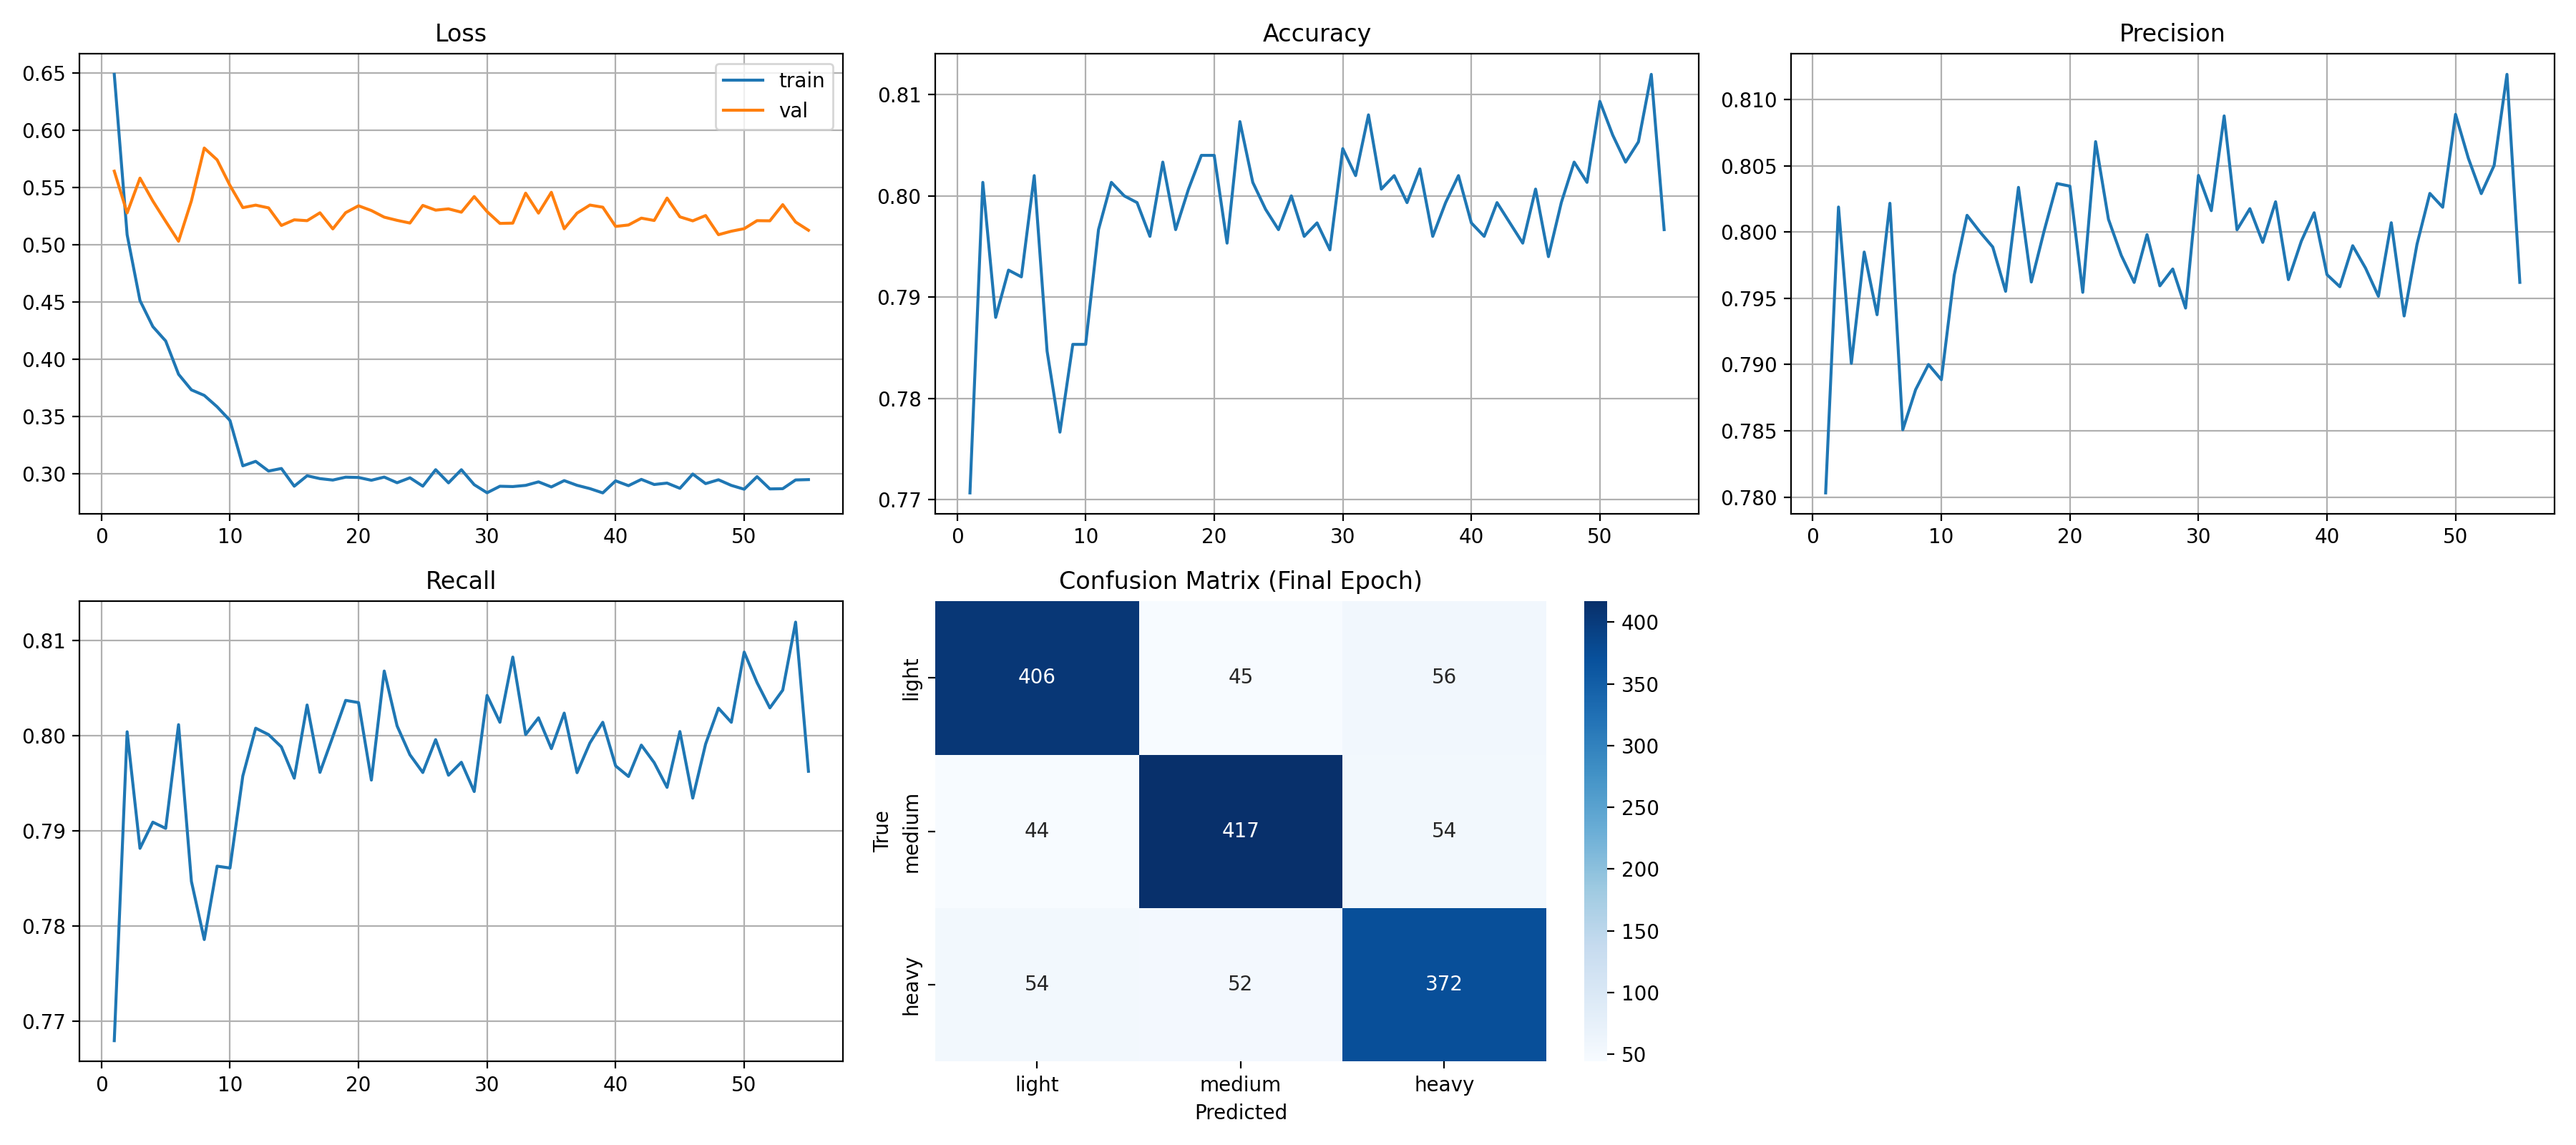

In [35]:
# Load best model from Stage 1
model.load_state_dict(
    torch.load(WEIGHTS_DIR / BEST_MODEL_NAME, map_location=DEVICE)
)

EPOCHS_STAGE2 = 15
FINE_TUNE_LR = 1e-5
FINETUNED_BEST_MODEL = "resnet50_clothing_classification_finetuned_best.pth"

# Reset best metric for stage 2
best_val_acc_stage2 = 0.0

# Freeze everything
for param in model.parameters():
    param.requires_grad = False

# Unfreeze last TWO blocks (semantic clothing features)
for param in model.layer3.parameters():
    param.requires_grad = True

for param in model.layer4.parameters():
    param.requires_grad = True

# Unfreeze classifier
for param in model.fc.parameters():
    param.requires_grad = True

class_weights = torch.tensor([1.0, 1.1, 1.1]).to(DEVICE)
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.SGD(
    [
        {"params": model.layer3.parameters(), "lr": FINE_TUNE_LR},
        {"params": model.layer4.parameters(), "lr": FINE_TUNE_LR * 2},
        {"params": model.fc.parameters(),     "lr": FINE_TUNE_LR * 5},
    ],
    momentum=0.9,
    weight_decay=5e-4
)

scheduler = optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=EPOCHS_STAGE2,
    eta_min=1e-6
)

for epoch in range(EPOCHS_STAGE2):
    model.train()
    start = time.time()

    running_loss = 0.0
    correct = 0
    total = 0

    print(f"\nEpoch {epoch+1}/{EPOCHS_STAGE2} | Image Size {IMG_SIZE}")

    for imgs, labels in tqdm(train_loader, leave=False):
        imgs = imgs.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    scheduler.step()

    train_loss = running_loss / total
    train_acc = correct / total

    metrics = validate(model, val_loader, criterion, DEVICE)
    val_acc = metrics["accuracy"]

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(metrics["loss"])
    history["accuracy"].append(metrics["accuracy"])
    history["precision"].append(metrics["precision"])
    history["recall"].append(metrics["recall"])
    history["confusion_matrices"].append(metrics["confusion_matrix"])
    print(f"Train Loss: {train_loss:.3f} | Train Acc: {train_acc:.3f}")
    print(f"Val Loss:   {metrics['loss']:.3f} | Val Acc:   {val_acc:.3f}")
    print(f"Val Prec:   {metrics['precision']:.3f} | Val Rec:   {metrics['recall']:.3f}")

    # Save best Stage-2 model
    if val_acc > best_val_acc_stage2:
        best_val_acc_stage2 = val_acc
        torch.save(model.state_dict(), WEIGHTS_DIR / FINETUNED_BEST_MODEL)
        print(f"New best model saved (val_acc={best_val_acc_stage2:.4f})")

    print(f"Epoch time: {time.time() - start:.1f}s")

print(f"\nFinal best validation accuracy: {best_val_acc_stage2:.4f}")
# Plot results
results_image = plot_classification_training_results(history, tuple(CLASSES), WEIGHTS_DIR / 'clothing_classification_results.png')
display(results_image)


## Testing

### Utility Functions

In [36]:
@torch.no_grad()
def predict_clothing(
    image_path: str,
    model,
    device: str = "cpu",
    show: bool = True,
    img_size: int = 256,
):
    """
    Predict clothing thermal level (light / medium / heavy)
    using deterministic inference transforms.
    """

    model.eval()
    model = model.to(device)

    # ---- Inference transform (NO augmentation) ----
    inference_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
        ),
    ])

    # ---- Load image ----
    orig_img = Image.open(image_path).convert("RGB")

    # ---- Preprocess ----
    x = inference_transform(orig_img).unsqueeze(0).to(device)

    # ---- Inference ----
    logits = model(x)
    probs = F.softmax(logits, dim=1).squeeze(0)

    pred_idx = torch.argmax(probs).item()
    pred_class = CLASSES[pred_idx]
    confidence = probs[pred_idx].item()

    # ---- Visualization ----
    if show:
        plt.figure(figsize=(4, 4))
        plt.imshow(orig_img)
        plt.axis("off")
        plt.title(
            f"Clothing: {pred_class.upper()} "
            f"({confidence:.2%})",
            fontsize=12,
            fontweight="bold",
        )
        plt.show()

    # ---- Structured output ----
    return {
        "predicted_class": pred_class,
        "confidence": float(confidence),
        "prob_light": float(probs[0].item()),
        "prob_medium": float(probs[1].item()),
        "prob_heavy": float(probs[2].item()),
    }


### Testing on Images

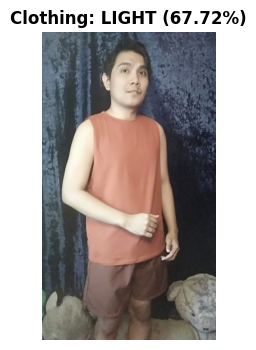

../../images/clothing_light.jpg {'predicted_class': 'light', 'confidence': 0.6772145628929138, 'prob_light': 0.6772145628929138, 'prob_medium': 0.19060692191123962, 'prob_heavy': 0.13217855989933014}


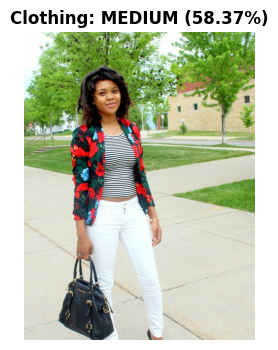

../../images/clothing_medium.jpg {'predicted_class': 'medium', 'confidence': 0.5836617946624756, 'prob_light': 0.4005599617958069, 'prob_medium': 0.5836617946624756, 'prob_heavy': 0.015778275206685066}


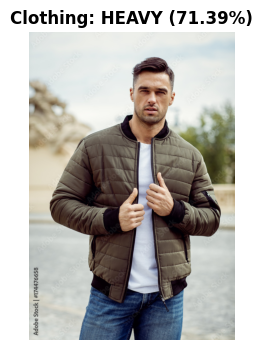

../../images/clothing_heavy.jpg {'predicted_class': 'heavy', 'confidence': 0.7139455676078796, 'prob_light': 0.13813306391239166, 'prob_medium': 0.14792129397392273, 'prob_heavy': 0.7139455676078796}


In [37]:
model.load_state_dict(torch.load(WEIGHTS_DIR / FINETUNED_BEST_MODEL, map_location=DEVICE))
print('../../images/clothing_light.jpg', predict_clothing(
    '../../images/clothing_light.jpg',
    model=model,
    device=DEVICE
))

print('../../images/clothing_medium.jpg', predict_clothing(
    '../../images/clothing_medium.jpg',
    model=model,
    device=DEVICE
))

print('../../images/clothing_heavy.jpg', predict_clothing(
    '../../images/clothing_heavy.jpg',
    model=model,
    device=DEVICE
))

## Comparison

### Utility Functions

In [38]:
def load_base_clothing_model(num_classes=3, device="cpu"):
    """
    ImageNet-pretrained ResNet50 (no finetuning).
    """
    model = models.resnet50(weights="IMAGENET1K_V2")
    model.fc = nn.Linear(model.fc.in_features, num_classes)

    model.to(device)
    model.eval()
    return model


def load_clothing_model(weights_path, num_classes=3, device="cpu"):
    """
    Load trained clothing classifier.
    """
    model = models.resnet50(weights=None)
    model.fc = nn.Linear(model.fc.in_features, num_classes)

    state_dict = torch.load(weights_path, map_location=device)
    model.load_state_dict(state_dict)

    model.to(device)
    model.eval()
    return model

def compare_clothing_models_with_training(
    base_model,
    initial_model,
    finetuned_model,
    train_loader,
    val_loader,
    criterion,
    device,
    class_names=("light", "medium", "heavy"),
    save_dir="results/clothing_confusion_matrices",
):
    models_dict = {
        "Base": base_model,
        "Initial": initial_model,
        "Fine-tuned": finetuned_model,
    }

    results = {}

    # ---- Evaluate ----
    for name, model in models_dict.items():
        results[name] = {
            "train": validate(model, train_loader, criterion, device),
            "val": validate(model, val_loader, criterion, device),
        }

    # ---- Numeric summary ----
    print("\nClothing Model Performance Comparison (Train vs Val)\n")
    header = f"{'Model':<12} {'Split':<6} {'Loss':>8} {'Acc':>8} {'Prec':>8} {'Rec':>8}"
    print(header)
    print("-" * len(header))

    for model_name, splits in results.items():
        for split in ["train", "val"]:
            m = splits[split]
            print(
                f"{model_name:<12} {split:<6} "
                f"{m['loss']:>8.4f} "
                f"{m['accuracy']:>8.4f} "
                f"{m['precision']:>8.4f} "
                f"{m['recall']:>8.4f}"
            )
        print("-" * len(header))

    # ---- Combined grid (3 models × 2 splits) ----
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(11, 12))

    for row, (model_name, splits) in enumerate(results.items()):
        for col, split in enumerate(["train", "val"]):
            cm = splits[split]["confusion_matrix"]

            sns.heatmap(
                cm,
                annot=True,
                fmt="d",
                cmap="Greens" if split == "train" else "Blues",
                xticklabels=class_names,
                yticklabels=class_names,
                ax=axes[row, col],
            )

            axes[row, col].set_title(f"{model_name} ({split})")
            axes[row, col].set_xlabel("Predicted")
            axes[row, col].set_ylabel("True")

    plt.tight_layout()
    plt.show()

    # ---- Save per-model grouped plots ----
    save_dir = Path(save_dir) / 'confusion_matrix'
    save_dir.mkdir(parents=True, exist_ok=True)

    for model_name, splits in results.items():
        fig, axes = plt.subplots(1, 2, figsize=(9, 4))

        for idx, split in enumerate(["train", "val"]):
            cm = splits[split]["confusion_matrix"]

            sns.heatmap(
                cm,
                annot=True,
                fmt="d",
                cmap="Greens" if split == "train" else "Blues",
                xticklabels=class_names,
                yticklabels=class_names,
                ax=axes[idx],
            )

            axes[idx].set_title(f"{split.capitalize()} Confusion Matrix")
            axes[idx].set_xlabel("Predicted")
            axes[idx].set_ylabel("True")

        fig.suptitle(f"{model_name} Clothing Model", fontsize=14)
        plt.tight_layout(rect=[0, 0, 1, 0.92])

        save_path = save_dir / f"{model_name.lower()}_clothing_cm.png"
        plt.savefig(save_path, dpi=200)
        plt.close()

        print(f"Saved grouped CM for {model_name}: {save_path}")

    return results


### Comparing Base Model vs Initial Model vs Finetuned Model


Clothing Model Performance Comparison (Train vs Val)

Model        Split      Loss      Acc     Prec      Rec
-------------------------------------------------------
Base         train    1.1024   0.3372   0.3422   0.3376
Base         val      1.1003   0.3520   0.3576   0.3511
-------------------------------------------------------
Initial      train    0.2686   0.9102   0.9102   0.9102
Initial      val      0.5241   0.8073   0.8068   0.8068
-------------------------------------------------------
Fine-tuned   train    0.2603   0.9147   0.9150   0.9147
Fine-tuned   val      0.5198   0.8120   0.8119   0.8119
-------------------------------------------------------


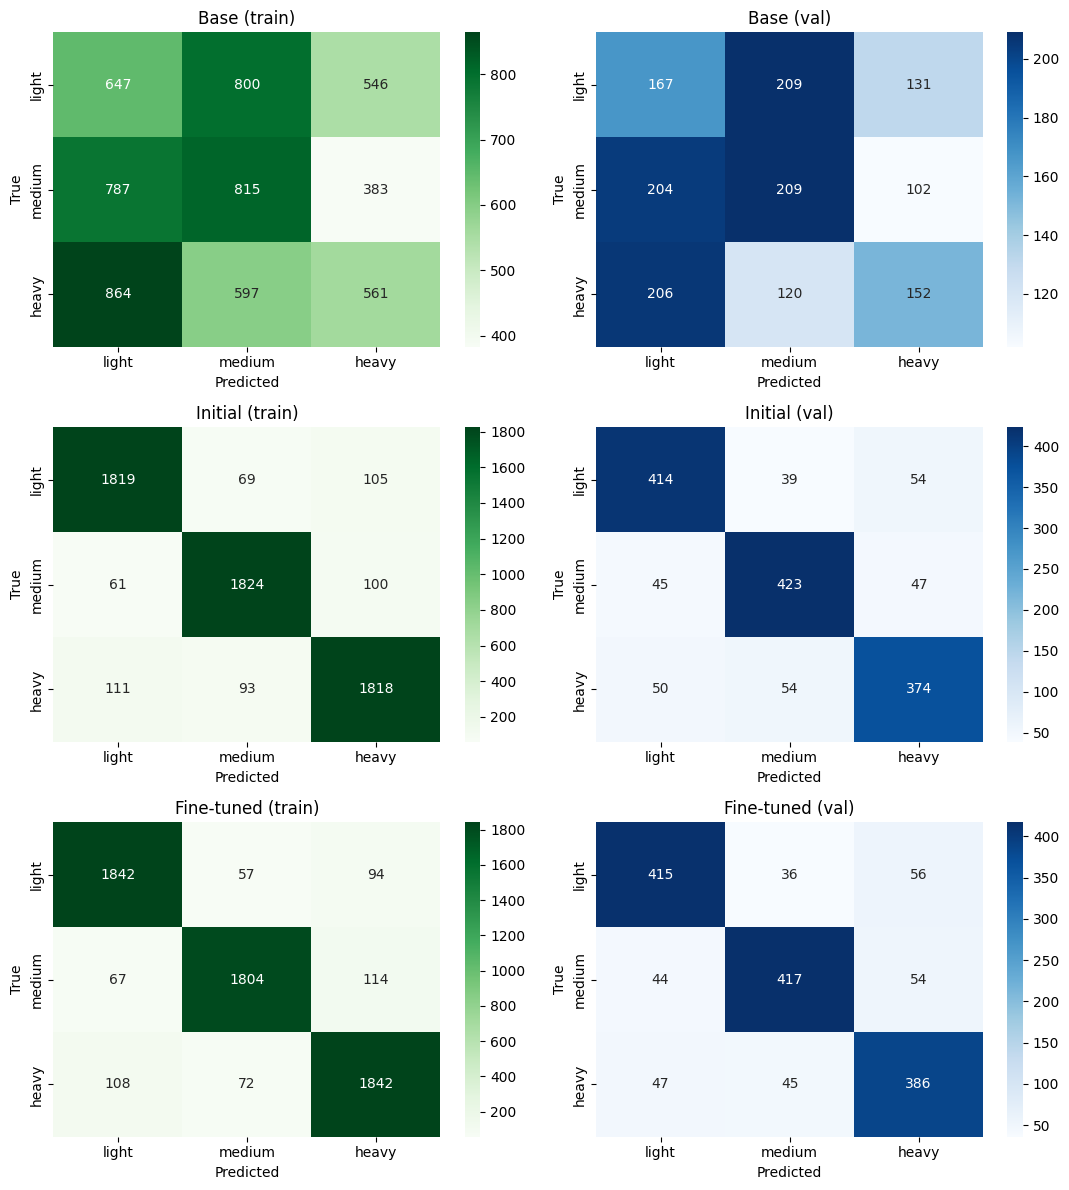

Saved grouped CM for Base: ../../runs/clothing_classification/results/confusion_matrix/base_clothing_cm.png
Saved grouped CM for Initial: ../../runs/clothing_classification/results/confusion_matrix/initial_clothing_cm.png
Saved grouped CM for Fine-tuned: ../../runs/clothing_classification/results/confusion_matrix/fine-tuned_clothing_cm.png


In [39]:
base_model = load_base_clothing_model(device=DEVICE)
initial_model = load_clothing_model(WEIGHTS_DIR / BEST_MODEL_NAME, device=DEVICE)
finetuned_model = load_clothing_model(WEIGHTS_DIR / FINETUNED_BEST_MODEL, device=DEVICE)

results = compare_clothing_models_with_training(
    base_model,
    initial_model,
    finetuned_model,
    train_loader,
    val_loader,
    criterion,
    DEVICE,
    class_names=("light", "medium", "heavy"),
    save_dir=RESULTS_DIR
)